In [1]:
from matplotlib import pyplot as plt
from itertools import product
import numpy as np
import pandas as pd
import os

In [2]:
import rasterio as rio
from rasterio.plot import show
from rasterio import plot
from rasterio import windows
import imageio
from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
from scipy.cluster.vq import whiten
from sklearn.cluster import KMeans

In [22]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [3]:
# set working directory
path = 'C:/Users/Changwha/Documents/02_UTK/03_2022FALL/COSC522/FinalProject'
os.chdir(path)
os.getcwd()

'C:\\Users\\Changwha\\Documents\\02_UTK\\03_2022FALL\\COSC522\\FinalProject'

In [4]:
# read jp2 files
## samples:
## f_18TYM245935_10, r_18TYM365890_55, s_19TCG165890_95, u_19TCG300905_44, w_18TYM215875_78 ##
imgjp2raw = rio.open('{}/sampledata/splitdata/s_19TCG165890_95.jp2'.format(path))
imgjp2raw.shape

(1000, 1000)

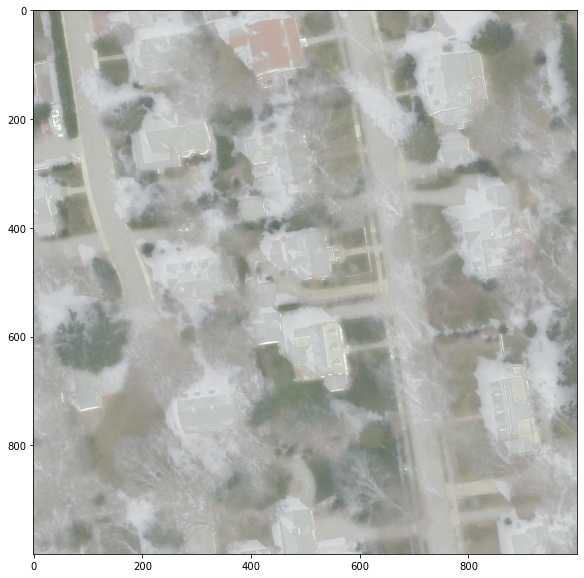

<AxesSubplot:>

In [5]:
plt.rcParams['figure.figsize'] = [10, 10]
plot.show(imgjp2raw.read())

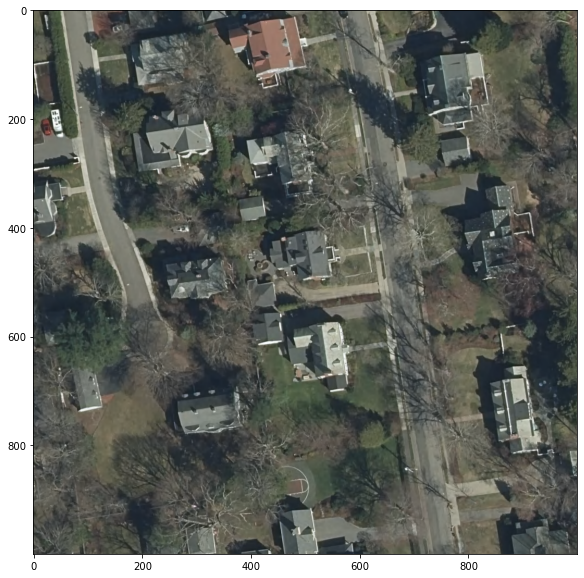

<AxesSubplot:>

In [6]:
plot.show(imgjp2raw.read([1, 2, 3]))

In [7]:
imgjp2 = np.array(imgjp2raw.read())
imgjp2.shape

(4, 1000, 1000)

In [8]:
imgrshp = np.empty(shape = (1000, 1000, 4))
dim = imgjp2.shape
for k in range(dim[0]):
    for i in range(dim[1]):
        for j in range(dim[2]):
            imgrshp[i][j][k] = np.int(imgjp2[k][i][j])

del i, j, k
imgrshp.shape

C:\Users\Changwha\AppData\Local\Temp\ipykernel_8452\3739192801.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imgrshp[i][j][k] = np.int(imgjp2[k][i][j])


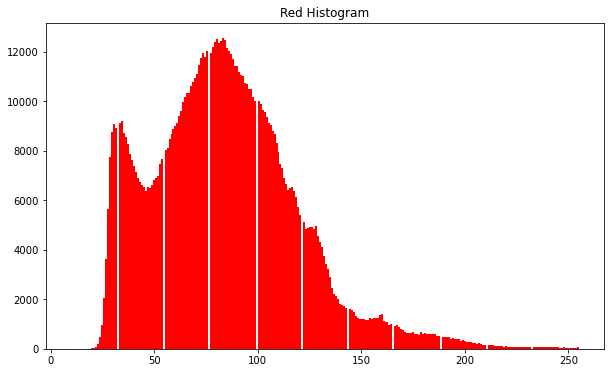

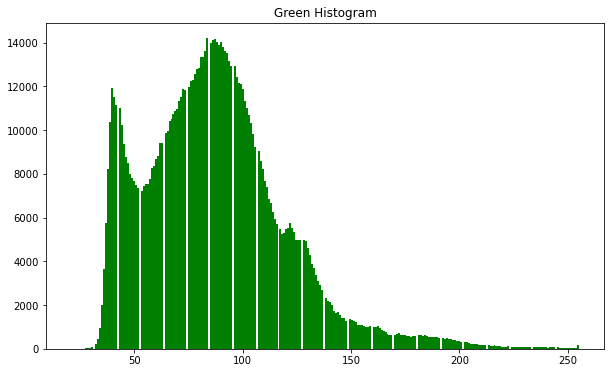

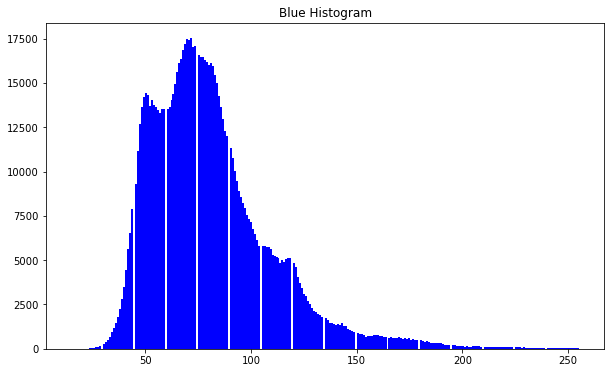

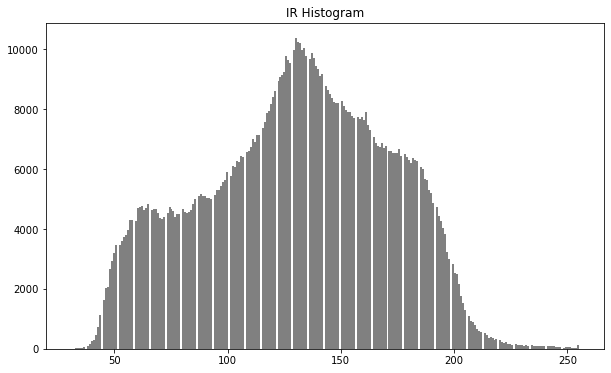

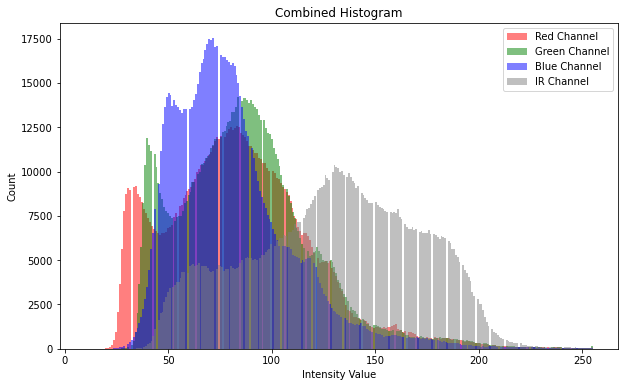

In [45]:
# Showing color intensity distribution in a histogram
plt.rcParams['figure.figsize'] = [10, 6]
# Obtain the red channel
red_channel = imgrshp[:, :, 0]
plt.hist(red_channel.ravel(), bins = 256, color = 'red') # with bins in a range of 256
plt.title('Red Histogram')
plt.show()

# Obtain the green channel
green_channel = imgrshp[:, :, 1]
plt.hist(green_channel.ravel(), bins = 256, color = 'green')
plt.title('Green Histogram')
plt.show()

# Obtain the blue channel
blue_channel = imgrshp[:, :, 2]
plt.hist(blue_channel.ravel(), bins = 256, color = 'blue')
plt.title('Blue Histogram')
plt.show()

# Obtain the IR channel
IR_channel = imgrshp[:, :, 3]
plt.hist(IR_channel.ravel(), bins = 256, color = 'grey')
plt.title('IR Histogram')
plt.show()

# Combined Histogram
plt.hist(red_channel.ravel(), bins = 256, color = 'red', alpha = 0.5)
plt.hist(green_channel.ravel(), bins = 256, color = 'green', alpha = 0.5)
plt.hist(blue_channel.ravel(), bins = 256, color = 'blue', alpha = 0.5)
plt.hist(IR_channel.ravel(), bins = 256, color = 'grey', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Red Channel', 'Green Channel', 'Blue Channel', 'IR Channel'])
plt.title('Combined Histogram')
plt.show()

In [29]:
print(np.mean(red_channel))
print(np.median(red_channel))
print(np.std(red_channel))
print(np.mean(green_channel))
print(np.median(green_channel))
print(np.std(green_channel))
print(np.mean(blue_channel))
print(np.median(blue_channel))
print(np.std(blue_channel))
print(np.mean(IR_channel))
print(np.median(IR_channel))
print(np.std(IR_channel))

84.24896
82.0
35.055404788968
87.412545
85.0
32.71288400039005
80.844495
76.0
29.10630181240782
129.825268
132.0
40.87761246364784


In [30]:
# alternative import method (only RGB)
imgrgb = imageio.imread('{}/sampledata/splitdatajpeg/u_19TCG300905_0.jpg'.format(path))
#plt.rcParams['figure.figsize'] = [10, 10]
#plt.imshow(imgrgb)

In [33]:
# standardizing pixel values
imgrshp_std = (imgrshp - np.mean(imgrshp, axis = (1, 2), keepdims = True)) / np.std(imgrshp, axis = (1, 2), keepdims = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


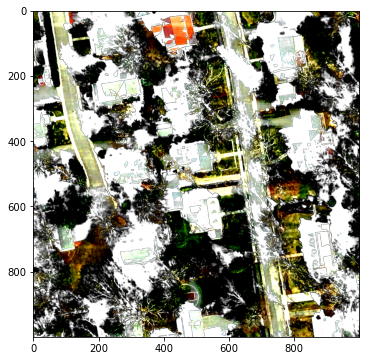

In [37]:
plt.imshow(imgrshp_std)

In [10]:
# Extract dominant colors
# Store RGB values of all pixels in lists r, g and b
r = []
g = []
b = []
for row in imgrshp:
    for temp_r, temp_g, temp_b, temp_IR in row:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)
  
# only printing the size of these lists
# as the content is too big
print(len(r))
print(len(g))
print(len(b))
  
# Saving as DataFrame
imgrshp_df = pd.DataFrame({'red': r, 'green': g, 'blue': b})
  
# Scaling the values
imgrshp_df['scaled_color_red'] = whiten(imgrshp_df['red'])
imgrshp_df['scaled_color_blue'] = whiten(imgrshp_df['blue'])
imgrshp_df['scaled_color_green'] = whiten(imgrshp_df['green'])

del r, g, b, row, temp_r, temp_g, temp_b, temp_IR

1000000
1000000
1000000


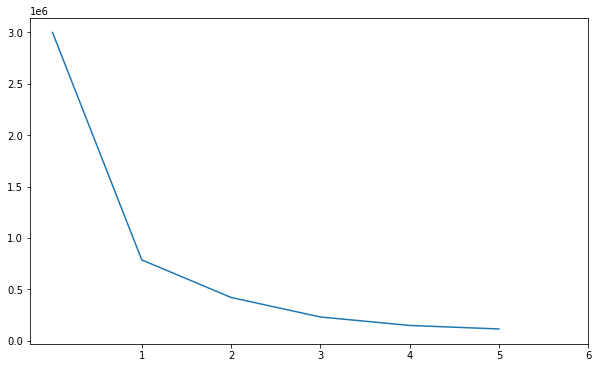

In [17]:
# OPTIONAL
# Preparing data to construct elbow plot
distortions = []
num_clusters = range(1, 7)  #range of cluster sizes

# Create a list of distortions from the kmeans function
for i in num_clusters:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(imgrshp_df[['scaled_color_red', 'scaled_color_blue', 'scaled_color_green']])
    distortions.append(kmeans.inertia_)
      
# Create a data frame with two lists, num_clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters' : num_clusters, 'distortions' : distortions})
  
# Create a line plot of num_clusters and distortions
plt.rcParams['figure.figsize'] = [10, 6]
plt.plot(elbow_plot['distortions'])
plt.xticks(num_clusters)
plt.show()

In [18]:
kmeans.cluster_centers_

array([[1.55589439, 1.96789355, 1.77701907],
       [4.00060551, 4.82400754, 4.37685951],
       [0.87709916, 1.37114563, 1.10245879],
       [2.77568102, 3.03491499, 2.92039327],
       [2.23691524, 2.55072117, 2.4057999 ],
       [3.31357299, 3.70943991, 3.52708405]])

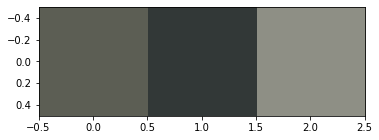

In [52]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(imgrshp_df[['scaled_color_red', 'scaled_color_green', 'scaled_color_blue']])
dominant_colors = []
  
# Get standard deviations of each color
red_std, green_std, blue_std = imgrshp_df[['red', 'green', 'blue']].std()
  
for cluster_center in kmeans.cluster_centers_:
    red_scaled, green_scaled, blue_scaled = cluster_center
  
    # Convert each standardized value to scaled value
    dominant_colors.append((red_scaled * red_std / 255, green_scaled * green_std / 255, blue_scaled * blue_std / 255))

del cluster_center

# Display colors of cluster centers
plt.rcParams['figure.figsize'] = [6, 2]
plt.imshow([dominant_colors])
plt.show()

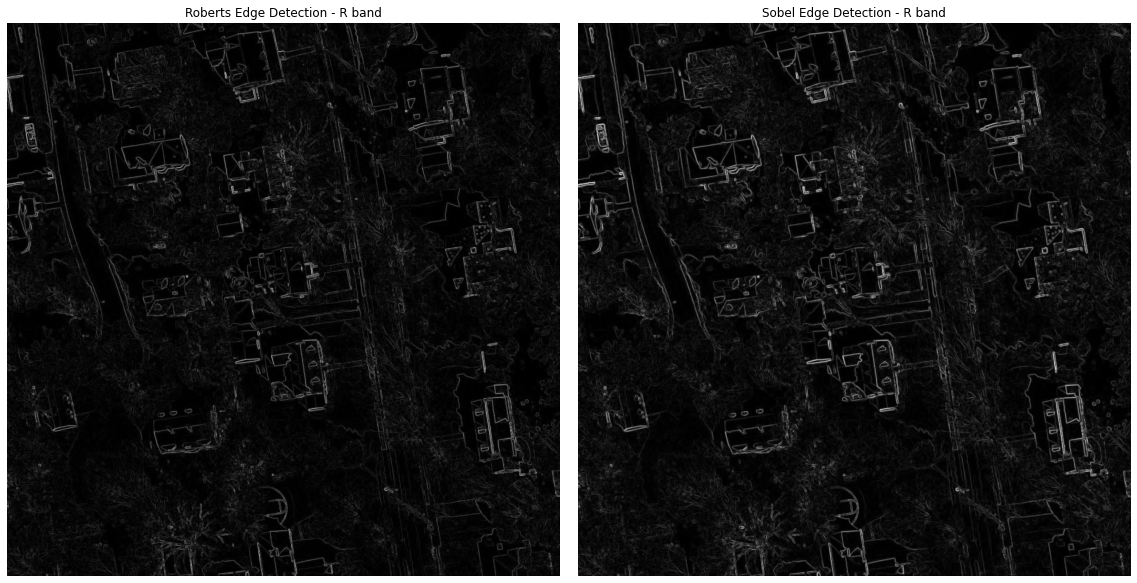

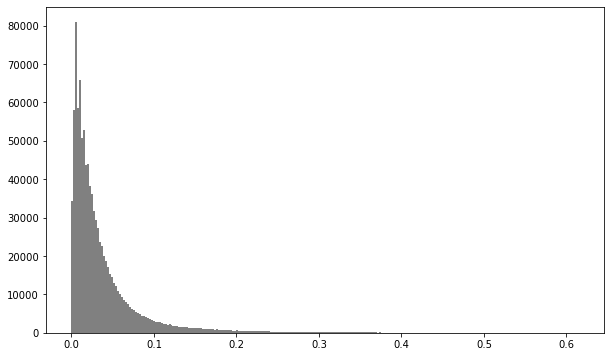

0.03777482443401296
0.022356380884296832
0.04840505013825753


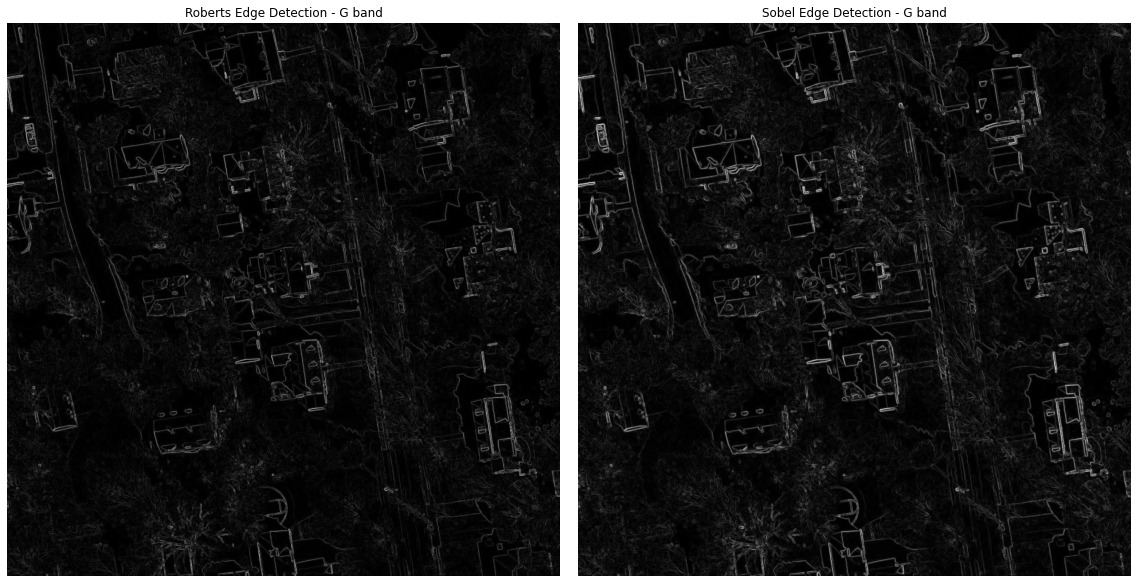

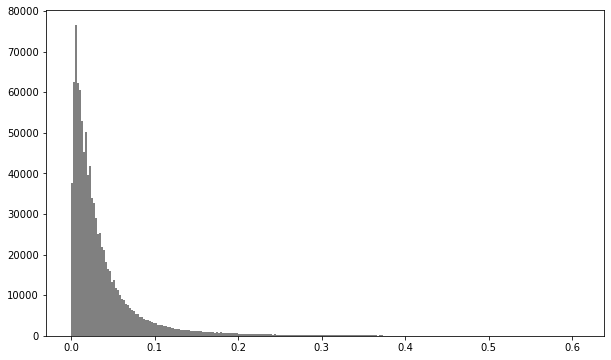

0.037414700221162944
0.022031573582592383
0.04821538894383472


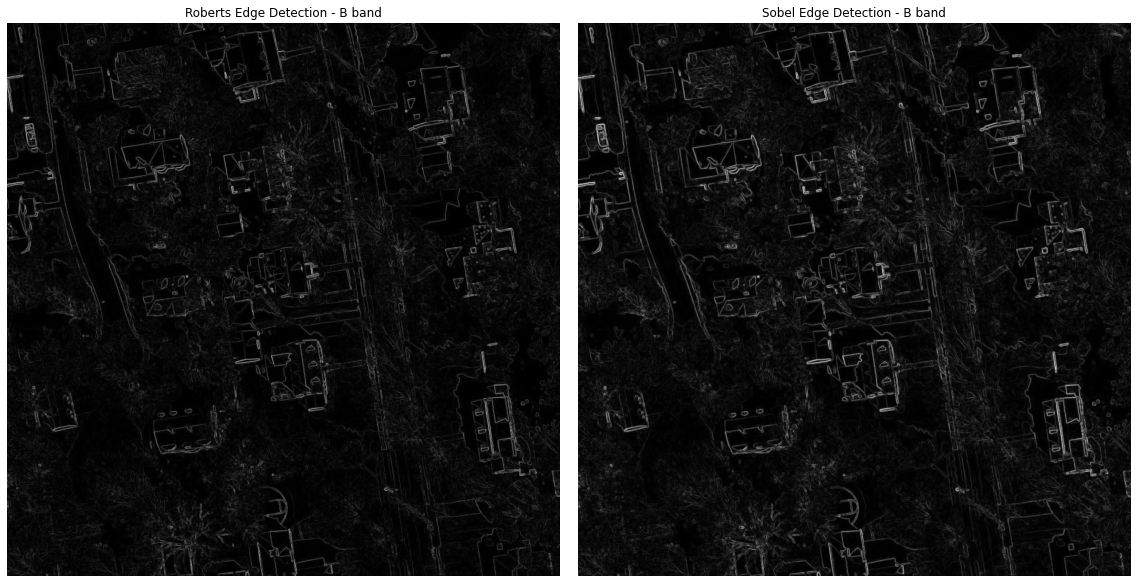

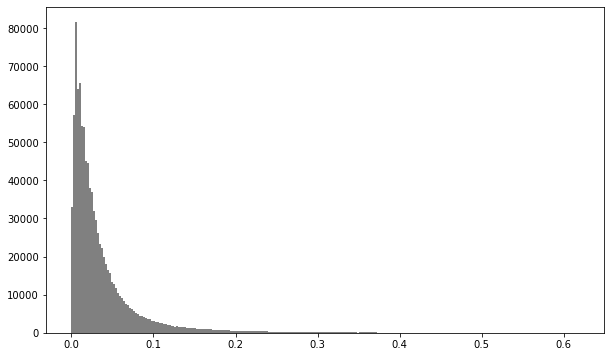

0.0372199985229509
0.021768238540367166
0.048112058229627754


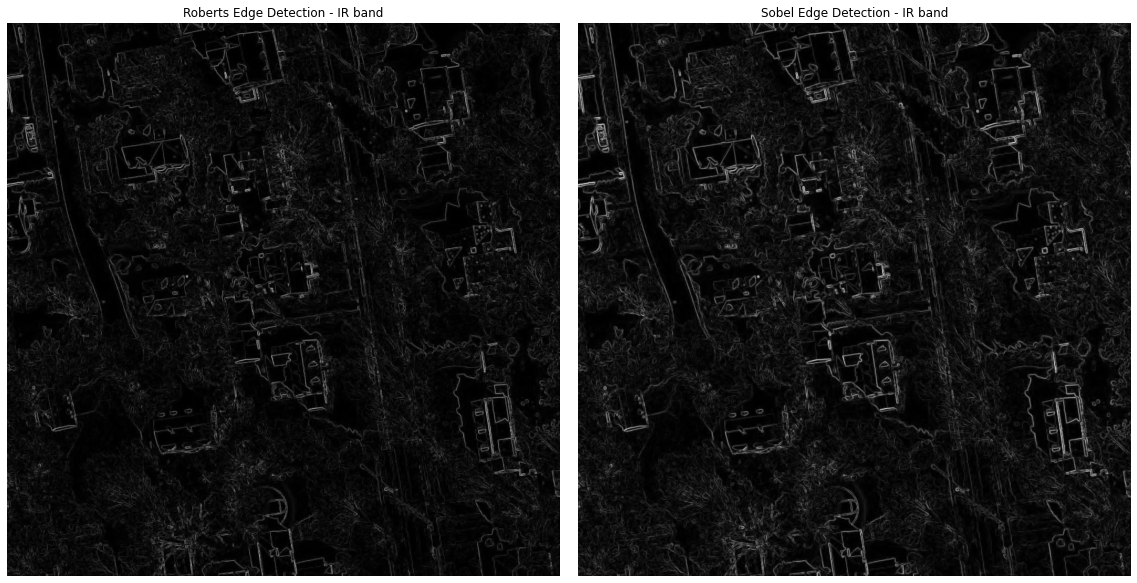

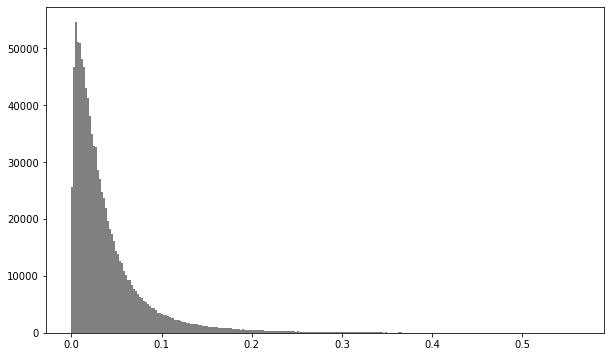

0.03947651522781988
0.025433572100142854
0.04515639175833961


In [53]:
# Edge detection
bands = ['R', 'G', 'B', 'IR']
for i in [1, 2, 3, 4]:
    edge_roberts = filters.roberts(imgjp2raw.read([i][0]))
    edge_sobel = filters.sobel(imgjp2raw.read([i][0]))

    fig, axes = plt.subplots(ncols = 2, sharex = True, sharey = True, figsize = (16, 8))

    axes[0].imshow(edge_roberts, cmap = plt.cm.gray)
    axes[0].set_title('Roberts Edge Detection - {} band'.format(bands[i - 1]))

    axes[1].imshow(edge_sobel, cmap = plt.cm.gray)
    axes[1].set_title('Sobel Edge Detection - {} band'.format(bands[i - 1]))

    for ax in axes:
        ax.axis('off')
    
    del ax

    plt.tight_layout()
    plt.show()

    plt.rcParams['figure.figsize'] = [10, 6]
    plt.hist(edge_sobel.ravel(), bins = 256, color = 'grey')
    plt.show()

    print(np.mean(edge_sobel))
    print(np.median(edge_sobel))
    print(np.std(edge_sobel))

del i

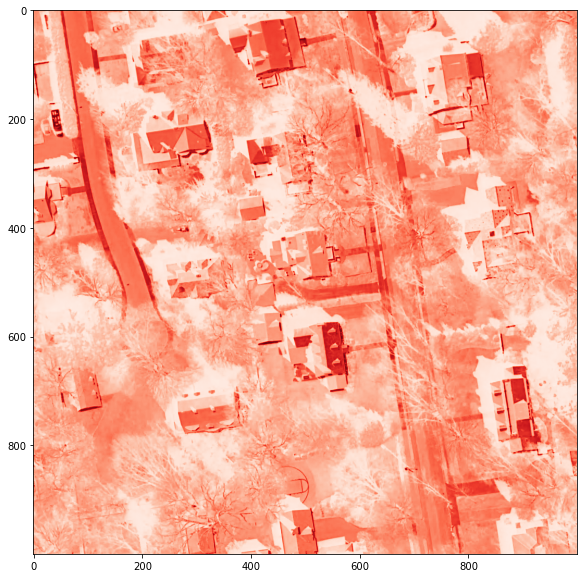

<AxesSubplot:>

In [117]:
# display the red band
plt.rcParams['figure.figsize'] = [10, 10]
plot.show(imgjp2raw.read([1]), cmap = 'Reds')

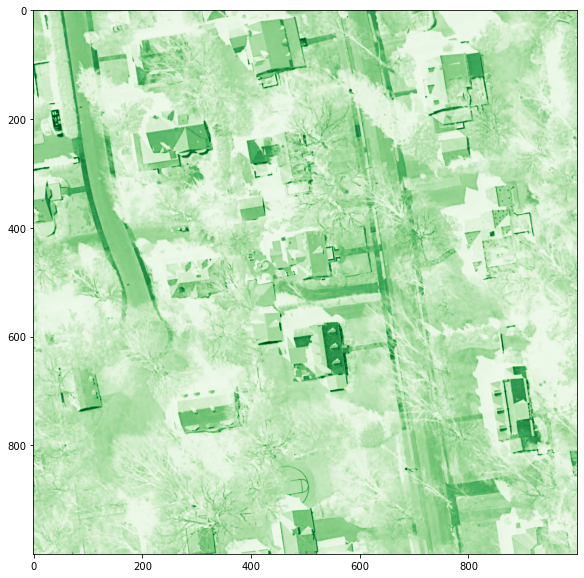

<AxesSubplot:>

In [118]:
# display the green band
plt.rcParams['figure.figsize'] = [10, 10]
plot.show(imgjp2raw.read([2]), cmap = 'Greens')

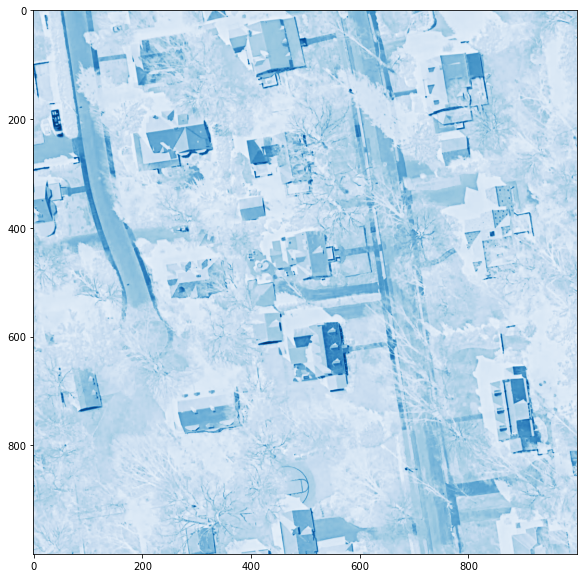

<AxesSubplot:>

In [119]:
# display the blue band
plt.rcParams['figure.figsize'] = [10, 10]
plot.show(imgjp2raw.read([3]), cmap = 'Blues')

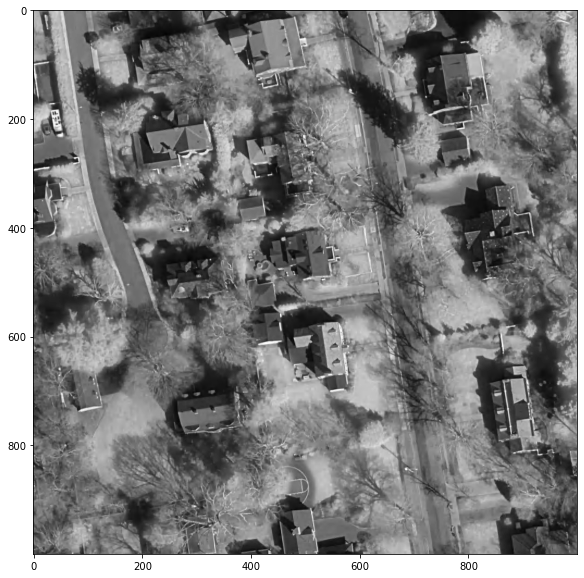

<AxesSubplot:>

In [120]:
# display the IR band
plot.show(imgjp2raw.read([4]), cmap = 'gray')

In [ ]:
#Feature integration


# x: data sets, y: label sets
xtrain, xtest, ytrain, ytest = train_test_split(data_res, labels_res, test_size = 0.30, random_state = 42)

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('accuracy: {}'.format(accuracy))